In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import haversine_distances

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 51.8 MB/s 
     |████████████████████████████████| 103 kB 77.7 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    cat_num = 100
    feat_columns = ['name', 'address', 'city', 
                'state', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):
    latlon_values = data.loc[df['id'], ['latitude', 'longitude']].values
    matlatlon_values = data.loc[df['match_id'], ['latitude', 'longitude']].values
    distances = []
    cnt = 0
    for latlon, matlatlon in tqdm(zip(latlon_values, matlatlon_values)):
        distances.append(haversine_distances([latlon, matlatlon])[0, 1])

        cnt += 1
        if cnt % 1000000 == 0:
            gc.collect()
    
    df['distance'] = distances

    del latlon_values, matlatlon_values, distances
    gc.collect()

    cat_values = data.loc[df['id']]['categories'].values.astype(str)
    matcat_values = data.loc[df['match_id']]['categories'].values.astype(str)
    cat_dist_percentile1 = []
    cat_dist_percentile2 = []

    cat2dist_distances_num = cat2dist['distances_num'].values
    cat2dist_distances = cat2dist['distances'].values
    cat2idx = {cat:i for i, cat in enumerate(cat2dist.index)}

    cnt = 0
    for s, distance in tqdm(zip(cat_values, df['distance'].values)):
        max_cat = 'unknown'
        max_cat_num = CFG.cat_num
        for cat in s.split(', '):
            if cat != 'nan' and cat in categories:
                cat_num = cat2dist_distances_num[cat2idx[cat]]
                if cat_num > max_cat_num:
                    max_cat_num = cat_num
                    max_cat = cat
        cat_distances = cat2dist_distances[cat2idx[max_cat]]
        cat_dist_percentile1.append((cat_distances < distance).astype(int).mean())

        cnt += 1
        if cnt % 1000000 == 0:
            gc.collect()

    gc.collect()
    
    cnt = 0
    for s, distance in tqdm(zip(matcat_values, df['distance'].values)):
        max_cat = 'unknown'
        max_cat_num = CFG.cat_num
        for cat in s.split(', '):
            if cat != 'nan' and cat in categories:
                cat_num = cat2dist_distances_num[cat2idx[cat]]
                if cat_num > max_cat_num:
                    max_cat_num = cat_num
                    max_cat = cat
        cat_distances = cat2dist_distances[cat2idx[max_cat]]
        cat_dist_percentile2.append((cat_distances < distance).astype(int).mean())

        cnt += 1
        if cnt % 1000000 == 0:
            gc.collect()
    
    gc.collect()

    df['cat_dist_percentile1'] = cat_dist_percentile1
    df['cat_dist_percentile2'] = cat_dist_percentile2

    del cat_values, matcat_values, cat_dist_percentile1, cat_dist_percentile2, cat2dist_distances_num, cat2dist_distances
    gc.collect()

    for col in tqdm(CFG.feat_columns):
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        vc = data[col].value_counts()
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
        gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 100000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

Calculate distances between matched entities

In [ ]:
cat2dis_data = data[data['set'] == 0]

In [ ]:
poi2distances = {}
all_distances = []
for poi, df in tqdm(cat2dis_data[["latitude", "longitude", "point_of_interest"]].groupby("point_of_interest"),
                    total=cat2dis_data["point_of_interest"].nunique()):
    if len(df) == 1:
        # no matches
        continue
        
    distances = []
    distances_mat = haversine_distances(df[["latitude", "longitude"]].values)
    for i in range(len(df) - 1):
        for j in range(i + 1, len(df)):
            # haversine distance -> meters
            distances.append(distances_mat[i, j])
            all_distances.append(distances_mat[i, j])
    poi2distances[poi] = distances

  0%|          | 0/369986 [00:00<?, ?it/s]

In [ ]:
poi2distances_df = pd.DataFrame({
    "point_of_interest": list(poi2distances.keys()),
    "distances": list(poi2distances.values())
})
poi2distances_df.head()

,point_of_interest,distances
0,P_0000c58a53df6d,[0.002288377953984225]
1,P_00010455487fcf,[0.0004857766987403706]
2,P_000116a2d0a467,[0.0003377296227570637]
3,P_00019fb954100b,[0.016459019668901686]
4,P_00027058a58996,[0.00028316048697444137]


Split categories, merge with distances per point_of_interest

In [ ]:
cat2dis_data["categories"] = cat2dis_data["categories"].fillna("").map(lambda x: x.split(", "))
cat2dis_data_ = cat2dis_data[["id", "name", "categories", "point_of_interest"]].merge(
    poi2distances_df, on="point_of_interest", how="inner")
cat2dis_data_["median_distances"] = cat2dis_data_["distances"].map(np.median)
cat2dis_data_.head()

,id,name,categories,point_of_interest,distances,median_distances
0,E_000002eae2a589,Carioca Manero,[Brazilian Restaurants],P_d82910d8382a83,[0.0002270160308670873],0.000227
1,E_e80db432029aea,Carioca Manero,"[Bars, Snack Places]",P_d82910d8382a83,[0.0002270160308670873],0.000227
2,E_000023d8f4be44,Island Spa,[Spas],P_020de174484ec6,[0.0007648195740532826],0.000765
3,E_12453effe251db,Island Spa Theater,[Spas],P_020de174484ec6,[0.0007648195740532826],0.000765
4,E_0000d9e584ed9f,Signature Properties Savannah,[Real Estate Offices],P_af856e3abdcebc,[0.00463056196777935],0.004631


Aggregate distances for each categories

In [ ]:
# make each row has only one category
exploded = cat2dis_data_.explode("categories").drop_duplicates(["point_of_interest", "categories"])
exploded.head()

,id,name,categories,point_of_interest,distances,median_distances
0,E_000002eae2a589,Carioca Manero,Brazilian Restaurants,P_d82910d8382a83,[0.0002270160308670873],0.000227
1,E_e80db432029aea,Carioca Manero,Bars,P_d82910d8382a83,[0.0002270160308670873],0.000227
1,E_e80db432029aea,Carioca Manero,Snack Places,P_d82910d8382a83,[0.0002270160308670873],0.000227
2,E_000023d8f4be44,Island Spa,Spas,P_020de174484ec6,[0.0007648195740532826],0.000765
4,E_0000d9e584ed9f,Signature Properties Savannah,Real Estate Offices,P_af856e3abdcebc,[0.00463056196777935],0.004631


In [ ]:
cat2dist = exploded.groupby("categories")['distances'].apply(lambda x: np.array(list(itertools.chain.from_iterable(x))))
cat2dist = cat2dist.reset_index()
cat2dist.loc[0, 'categories'] = 'unknown'
cat2dist['distances'][0] = np.array(all_distances)
cat2dist['distances_num'] = cat2dist['distances'].map(len)

In [ ]:
cat2dist.head()

,categories,distances,distances_num
0,unknown,"[0.002288377953984225, 0.0004857766987403706, ...",488144
1,ATMs,"[0.0, 0.0005935208131384233, 0.008514918716458...",1231
2,Acai Houses,"[0.001365053899785685, 0.021202317098512818, 0...",14
3,Accessories Stores,"[8.001115039381182e-06, 0.11833767331271419, 0...",634
4,Acehnese Restaurants,"[0.0011796681951925748, 0.00016238913050424747...",110


In [ ]:
del cat2dis_data, cat2dis_data_, poi2distances_df, exploded
gc.collect()

159

In [ ]:
categories = set(cat2dist['categories'])
cat2dist = cat2dist.set_index('categories')

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
features = ['distance', 'cat_dist_percentile1', 'cat_dist_percentile2', 'kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

63
['distance', 'cat_dist_percentile1', 'cat_dist_percentile2', 'kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'categories_CE_1', 'categories_CE_2'

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0423824
[100]	valid_0's binary_logloss: 0.0398597
[150]	valid_0's binary_logloss: 0.038711
[200]	valid_0's binary_logloss: 0.0380043
[250]	valid_0's binary_logloss: 0.037436
[300]	valid_0's binary_logloss: 0.0369777
[350]	valid_0's binary_logloss: 0.0365878
[400]	valid_0's binary_logloss: 0.03629
[450]	valid_0's binary_logloss: 0.0359881
[500]	valid_0's binary_logloss: 0.0357201
[550]	valid_0's binary_logloss: 0.0354844
[600]	valid_0's binary_logloss: 0.0352415
[650]	valid_0's binary_logloss: 0.0350086
[700]	valid_0's binary_logloss: 0.0348243
[750]	valid_0's binary_logloss: 0.0346396
[800]	valid_0's binary_logloss: 0.0344275
[850]	valid_0's binary_logloss: 0.0342527
[900]	valid_0's binary_logloss: 0.0341216
[950]	valid_0's binary_logloss: 0.0339356
[1000]	valid_0's binary_logloss: 0.0337973
[1050]	valid_0's binary_logloss: 0.0336746
[1100]	valid_0's binary_logloss: 0.0335172
[1150]	valid_0's binary_logloss: 0.0334159
[1200]	valid_0's binary_logloss: 0.

In [ ]:
del train_data
gc.collect()

87

#Check Feature Importances

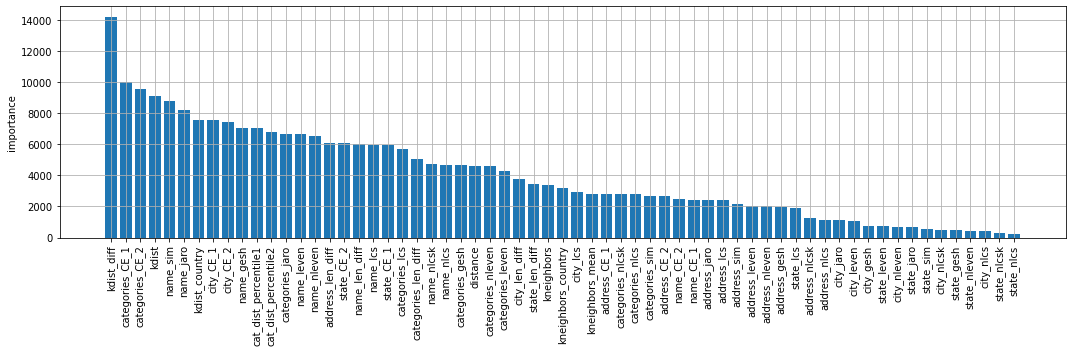

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 9.9 MB/s 
     |████████████████████████████████| 210 kB 66.7 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 112 kB 80.4 MB/s 
     |████████████████████████████████| 146 kB 72.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e5378266bb8a0f48707d2ccadaa047869ce38fcbd5ff1ca055bd50546ed32b91
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-29 10:18:19,975] A new study created in memory with name: no-name-cc32167f-6665-4de5-b3cb-4ec317ef0766
[I 2022-05-29 10:18:45,110] Trial 0 finished with value: 0.8290853855092373 and parameters: {'threshold': 0.2690634043531196}. Best is trial 0 with value: 0.8290853855092373.


CV: 0.829085


[I 2022-05-29 10:19:04,437] Trial 1 finished with value: 0.8375132081517044 and parameters: {'threshold': 0.7418170598142756}. Best is trial 1 with value: 0.8375132081517044.


CV: 0.837513


[I 2022-05-29 10:19:23,523] Trial 2 finished with value: 0.8339727463903945 and parameters: {'threshold': 0.32602525091560774}. Best is trial 1 with value: 0.8375132081517044.


CV: 0.833973


[I 2022-05-29 10:19:41,800] Trial 3 finished with value: 0.8169909446235258 and parameters: {'threshold': 0.9081835323447713}. Best is trial 1 with value: 0.8375132081517044.


CV: 0.816991


[I 2022-05-29 10:20:01,840] Trial 4 finished with value: 0.8299477134827754 and parameters: {'threshold': 0.27806679815745616}. Best is trial 1 with value: 0.8375132081517044.


CV: 0.829948


[I 2022-05-29 10:20:21,433] Trial 5 finished with value: 0.7899493515551961 and parameters: {'threshold': 0.0949443073224362}. Best is trial 1 with value: 0.8375132081517044.


CV: 0.789949


[I 2022-05-29 10:20:40,657] Trial 6 finished with value: 0.8356450214246854 and parameters: {'threshold': 0.7710581982679156}. Best is trial 1 with value: 0.8375132081517044.


CV: 0.835645


[I 2022-05-29 10:20:58,943] Trial 7 finished with value: 0.8360904911024694 and parameters: {'threshold': 0.7647484299755868}. Best is trial 1 with value: 0.8375132081517044.


CV: 0.836090


[I 2022-05-29 10:21:18,365] Trial 8 finished with value: 0.8060713636927578 and parameters: {'threshold': 0.13712948343853726}. Best is trial 1 with value: 0.8375132081517044.


CV: 0.806071


[I 2022-05-29 10:21:37,000] Trial 9 finished with value: 0.8406192285602001 and parameters: {'threshold': 0.46914427072813936}. Best is trial 9 with value: 0.8406192285602001.


CV: 0.840619


[I 2022-05-29 10:21:56,429] Trial 10 finished with value: 0.8416051880781341 and parameters: {'threshold': 0.5275538938810853}. Best is trial 10 with value: 0.8416051880781341.


CV: 0.841605


[I 2022-05-29 10:22:14,923] Trial 11 finished with value: 0.8416028379343055 and parameters: {'threshold': 0.5273274422829002}. Best is trial 10 with value: 0.8416051880781341.


CV: 0.841603


[I 2022-05-29 10:22:34,392] Trial 12 finished with value: 0.8417812788631219 and parameters: {'threshold': 0.552132866247835}. Best is trial 12 with value: 0.8417812788631219.


CV: 0.841781


[I 2022-05-29 10:22:53,993] Trial 13 finished with value: 0.8418370340895676 and parameters: {'threshold': 0.5569796897612902}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841837


[I 2022-05-29 10:23:12,468] Trial 14 finished with value: 0.8412859191322162 and parameters: {'threshold': 0.6272192910242335}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841286


[I 2022-05-29 10:23:31,272] Trial 15 finished with value: 0.837700183143525 and parameters: {'threshold': 0.38689116422236103}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.837700


[I 2022-05-29 10:23:49,644] Trial 16 finished with value: 0.841579516733219 and parameters: {'threshold': 0.6114583578828596}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841580


[I 2022-05-29 10:24:09,760] Trial 17 finished with value: 0.7730822170812883 and parameters: {'threshold': 0.9805572866666217}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.773082


[I 2022-05-29 10:24:28,176] Trial 18 finished with value: 0.8408240096488103 and parameters: {'threshold': 0.6480436718354429}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.840824


[I 2022-05-29 10:24:47,792] Trial 19 finished with value: 0.838947930600121 and parameters: {'threshold': 0.4195818671735023}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.838948


[I 2022-05-29 10:25:05,950] Trial 20 finished with value: 0.8245757292100435 and parameters: {'threshold': 0.8730370806872956}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.824576


[I 2022-05-29 10:25:25,389] Trial 21 finished with value: 0.8415044976627435 and parameters: {'threshold': 0.5204401919664907}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841504


[I 2022-05-29 10:25:43,828] Trial 22 finished with value: 0.8416344752823257 and parameters: {'threshold': 0.5937900778922727}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841634


[I 2022-05-29 10:26:03,203] Trial 23 finished with value: 0.8402162396911085 and parameters: {'threshold': 0.6723694348373035}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.840216


[I 2022-05-29 10:26:21,738] Trial 24 finished with value: 0.8417096194800778 and parameters: {'threshold': 0.5804451441581668}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841710


[I 2022-05-29 10:26:40,520] Trial 25 finished with value: 0.8392739817683481 and parameters: {'threshold': 0.4282558700833852}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.839274


[I 2022-05-29 10:27:00,240] Trial 26 finished with value: 0.8347720776948974 and parameters: {'threshold': 0.3383554934365582}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.834772


[I 2022-05-29 10:27:19,711] Trial 27 finished with value: 0.8417581538660729 and parameters: {'threshold': 0.5672602075314265}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841758


[I 2022-05-29 10:27:38,147] Trial 28 finished with value: 0.8400095694643676 and parameters: {'threshold': 0.6795218448956951}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.840010


[I 2022-05-29 10:27:57,408] Trial 29 finished with value: 0.8202256745424686 and parameters: {'threshold': 0.20090762847516486}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.820226


[I 2022-05-29 10:28:19,745] Trial 30 finished with value: 0.6200563294404726 and parameters: {'threshold': 0.007412367776002238}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.620056


[I 2022-05-29 10:28:39,683] Trial 31 finished with value: 0.8417175967696718 and parameters: {'threshold': 0.5788460390979059}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841718


[I 2022-05-29 10:28:58,331] Trial 32 finished with value: 0.8407028817984799 and parameters: {'threshold': 0.47389149622805216}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.840703


[I 2022-05-29 10:29:18,180] Trial 33 finished with value: 0.8387153934554995 and parameters: {'threshold': 0.7156432519203825}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.838715


[I 2022-05-29 10:29:36,449] Trial 34 finished with value: 0.8315605426689464 and parameters: {'threshold': 0.8189414028675068}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.831561


[I 2022-05-29 10:29:55,779] Trial 35 finished with value: 0.8418018809161597 and parameters: {'threshold': 0.564552411012284}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841802


[I 2022-05-29 10:30:14,651] Trial 36 finished with value: 0.8366633894855314 and parameters: {'threshold': 0.36808600436922867}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.836663


[I 2022-05-29 10:30:34,771] Trial 37 finished with value: 0.8406282982682485 and parameters: {'threshold': 0.47066273662661123}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.840628


[I 2022-05-29 10:30:53,672] Trial 38 finished with value: 0.8290336882860165 and parameters: {'threshold': 0.2682506665365796}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.829034


[I 2022-05-29 10:31:12,919] Trial 39 finished with value: 0.8391076604204954 and parameters: {'threshold': 0.7060793657929854}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.839108


[I 2022-05-29 10:31:31,162] Trial 40 finished with value: 0.8340723065734028 and parameters: {'threshold': 0.7916632965109183}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.834072


[I 2022-05-29 10:31:49,483] Trial 41 finished with value: 0.8417276764519618 and parameters: {'threshold': 0.5767295954400596}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841728


[I 2022-05-29 10:32:08,897] Trial 42 finished with value: 0.8418357147228133 and parameters: {'threshold': 0.5558656938382824}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841836


[I 2022-05-29 10:32:27,295] Trial 43 finished with value: 0.8417169387276539 and parameters: {'threshold': 0.5412844031171719}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841717


[I 2022-05-29 10:32:47,113] Trial 44 finished with value: 0.8408923028492118 and parameters: {'threshold': 0.48186366001008607}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.840892


[I 2022-05-29 10:33:05,782] Trial 45 finished with value: 0.8410016406218823 and parameters: {'threshold': 0.641598794365592}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841002


[I 2022-05-29 10:33:24,406] Trial 46 finished with value: 0.8417448978843073 and parameters: {'threshold': 0.5482000667907644}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841745


[I 2022-05-29 10:33:43,943] Trial 47 finished with value: 0.8395175626407821 and parameters: {'threshold': 0.434780920958044}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.839518


[I 2022-05-29 10:34:02,172] Trial 48 finished with value: 0.8376677179672236 and parameters: {'threshold': 0.7392581855379585}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.837668


[I 2022-05-29 10:34:21,051] Trial 49 finished with value: 0.8411157023458824 and parameters: {'threshold': 0.4952898374606877}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841116


[I 2022-05-29 10:34:40,496] Trial 50 finished with value: 0.8414280877844346 and parameters: {'threshold': 0.6172963788779797}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841428


[I 2022-05-29 10:34:59,031] Trial 51 finished with value: 0.841739449059023 and parameters: {'threshold': 0.5422175688455618}. Best is trial 13 with value: 0.8418370340895676.


CV: 0.841739


[I 2022-05-29 10:35:18,489] Trial 52 finished with value: 0.8418482063129279 and parameters: {'threshold': 0.5593347148898997}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841848


[I 2022-05-29 10:35:36,795] Trial 53 finished with value: 0.8402704282017767 and parameters: {'threshold': 0.6697730597001419}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.840270


[I 2022-05-29 10:35:56,330] Trial 54 finished with value: 0.8414330747947502 and parameters: {'threshold': 0.5143440600773099}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841433


[I 2022-05-29 10:36:15,069] Trial 55 finished with value: 0.8380559888484866 and parameters: {'threshold': 0.3956968139239842}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.838056


[I 2022-05-29 10:36:34,609] Trial 56 finished with value: 0.8417707687219247 and parameters: {'threshold': 0.5694225639822176}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841771


[I 2022-05-29 10:36:53,385] Trial 57 finished with value: 0.8400167627921754 and parameters: {'threshold': 0.4508403617120149}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.840017


[I 2022-05-29 10:37:11,773] Trial 58 finished with value: 0.8414072997755752 and parameters: {'threshold': 0.6188251686432513}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841407


[I 2022-05-29 10:37:31,169] Trial 59 finished with value: 0.8415826301293382 and parameters: {'threshold': 0.6084389543045059}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841583


[I 2022-05-29 10:37:49,717] Trial 60 finished with value: 0.8413191646525124 and parameters: {'threshold': 0.5047742596843396}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841319


[I 2022-05-29 10:38:08,235] Trial 61 finished with value: 0.8417750292749837 and parameters: {'threshold': 0.5525880641322798}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841775


[I 2022-05-29 10:38:28,076] Trial 62 finished with value: 0.8418316479487179 and parameters: {'threshold': 0.5582192906114479}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841832


[I 2022-05-29 10:38:46,556] Trial 63 finished with value: 0.8405237047804186 and parameters: {'threshold': 0.6632145364473018}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.840524


[I 2022-05-29 10:39:05,012] Trial 64 finished with value: 0.8415087009042735 and parameters: {'threshold': 0.5216633305594317}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841509


[I 2022-05-29 10:39:24,451] Trial 65 finished with value: 0.8393684181212668 and parameters: {'threshold': 0.7000544473673791}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.839368


[I 2022-05-29 10:39:42,794] Trial 66 finished with value: 0.8416549576695971 and parameters: {'threshold': 0.5958259985567615}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841655


[I 2022-05-29 10:40:01,163] Trial 67 finished with value: 0.8411195239115471 and parameters: {'threshold': 0.6371389928989539}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841120


[I 2022-05-29 10:40:20,790] Trial 68 finished with value: 0.84176037646621 and parameters: {'threshold': 0.5509730542955993}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841760


[I 2022-05-29 10:40:39,521] Trial 69 finished with value: 0.8385096774110729 and parameters: {'threshold': 0.4073667404454031}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.838510


[I 2022-05-29 10:40:59,159] Trial 70 finished with value: 0.8401730932228569 and parameters: {'threshold': 0.4546572234505409}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.840173


[I 2022-05-29 10:41:17,546] Trial 71 finished with value: 0.841742006713265 and parameters: {'threshold': 0.5730942919313249}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841742


[I 2022-05-29 10:41:37,349] Trial 72 finished with value: 0.8411428855980004 and parameters: {'threshold': 0.49660100698994986}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841143


[I 2022-05-29 10:41:56,001] Trial 73 finished with value: 0.8417752755047102 and parameters: {'threshold': 0.5524180206677297}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841775


[I 2022-05-29 10:42:14,659] Trial 74 finished with value: 0.8416643168825182 and parameters: {'threshold': 0.5952572324394709}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841664


[I 2022-05-29 10:42:34,633] Trial 75 finished with value: 0.8415180023557746 and parameters: {'threshold': 0.522258413747921}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841518


[I 2022-05-29 10:42:52,965] Trial 76 finished with value: 0.8409886300521028 and parameters: {'threshold': 0.6422915945846518}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.840989


[I 2022-05-29 10:43:11,512] Trial 77 finished with value: 0.8417790040805111 and parameters: {'threshold': 0.5527933614162651}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841779


[I 2022-05-29 10:43:30,179] Trial 78 finished with value: 0.8399024655805564 and parameters: {'threshold': 0.4464580081361866}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.839902


[I 2022-05-29 10:43:49,769] Trial 79 finished with value: 0.8410219987674987 and parameters: {'threshold': 0.4885165257339029}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841022


[I 2022-05-29 10:44:08,571] Trial 80 finished with value: 0.8348599974809799 and parameters: {'threshold': 0.3396219660855762}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.834860


[I 2022-05-29 10:44:28,231] Trial 81 finished with value: 0.8417493035801921 and parameters: {'threshold': 0.5513234535484534}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841749


[I 2022-05-29 10:44:46,931] Trial 82 finished with value: 0.841797987114267 and parameters: {'threshold': 0.5643824484503559}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841798


[I 2022-05-29 10:45:06,333] Trial 83 finished with value: 0.8416733776025065 and parameters: {'threshold': 0.5886057569461314}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841673


[I 2022-05-29 10:45:24,966] Trial 84 finished with value: 0.8415788681936531 and parameters: {'threshold': 0.5291749928124703}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841579


[I 2022-05-29 10:45:44,548] Trial 85 finished with value: 0.8416008170734179 and parameters: {'threshold': 0.6073123562592122}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841601


[I 2022-05-29 10:46:03,268] Trial 86 finished with value: 0.8408196225951614 and parameters: {'threshold': 0.4786269293001133}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.840820


[I 2022-05-29 10:46:22,745] Trial 87 finished with value: 0.839917341675872 and parameters: {'threshold': 0.6820469394378778}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.839917


[I 2022-05-29 10:46:41,303] Trial 88 finished with value: 0.8417844005451741 and parameters: {'threshold': 0.563330852994888}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841784


[I 2022-05-29 10:47:00,730] Trial 89 finished with value: 0.8412623249404002 and parameters: {'threshold': 0.6316802422780077}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841262


[I 2022-05-29 10:47:19,181] Trial 90 finished with value: 0.8406587955015853 and parameters: {'threshold': 0.6582195347371488}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.840659


[I 2022-05-29 10:47:37,576] Trial 91 finished with value: 0.8417987212965525 and parameters: {'threshold': 0.5615299158194325}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841799


[I 2022-05-29 10:47:57,078] Trial 92 finished with value: 0.8417594067620131 and parameters: {'threshold': 0.5718908001300085}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841759


[I 2022-05-29 10:48:15,656] Trial 93 finished with value: 0.841580784061736 and parameters: {'threshold': 0.5289288030571863}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841581


[I 2022-05-29 10:48:34,362] Trial 94 finished with value: 0.8413204662417283 and parameters: {'threshold': 0.5046235248586339}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841320


[I 2022-05-29 10:48:53,901] Trial 95 finished with value: 0.8414158005563489 and parameters: {'threshold': 0.6186689574041832}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841416


[I 2022-05-29 10:49:12,447] Trial 96 finished with value: 0.841654051295777 and parameters: {'threshold': 0.5958886291423745}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841654


[I 2022-05-29 10:49:31,313] Trial 97 finished with value: 0.8405498667011324 and parameters: {'threshold': 0.4676358144948055}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.840550


[I 2022-05-29 10:49:49,865] Trial 98 finished with value: 0.774834672604979 and parameters: {'threshold': 0.9794236729110768}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.774835


[I 2022-05-29 10:50:08,501] Trial 99 finished with value: 0.8417881761080105 and parameters: {'threshold': 0.5637680330421816}. Best is trial 52 with value: 0.8418482063129279.


CV: 0.841788


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5593347148898997

In [ ]:
study.best_value

0.8418482063129279

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.841848


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,126523.000000,126523.000000,122540.000000,122540.000000,117179.000000,130557.000000,130557.0,130557.000000,130557.000000,130557.000000,...,96626.000000,96626.000000,96626.000000,110436.000000,110682.000000,130557.000000,96626.000000,96626.000000,96626.000000,1.305570e+05
mean,0.006785,6.348893,0.003564,6.381508,0.430856,6.655572,1.0,0.005706,0.281659,0.282217,...,12.569847,0.675507,9.157152,5608.189703,5625.606088,9.213730,0.536007,0.582585,0.583427,1.896920e-01
std,0.055989,5.272125,0.024166,5.280659,2.490625,5.330461,0.0,0.044953,0.218885,0.219021,...,11.708767,0.244057,7.417038,6768.545425,6774.018767,11.115403,0.354182,0.331014,0.330396,1.743095e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.415138e-11
25%,0.000455,2.000000,0.000341,2.000000,0.005732,2.000000,1.0,0.000358,0.098948,0.099851,...,0.000000,0.483333,4.000000,757.000000,757.000000,0.000000,0.000000,0.285714,0.285714,2.878275e-02
50%,0.001149,5.000000,0.000885,5.000000,0.057660,5.000000,1.0,0.000948,0.237756,0.237945,...,12.000000,0.583849,7.000000,2892.000000,2892.000000,6.000000,0.714286,0.486486,0.500000,1.372913e-01
75%,0.003127,10.000000,0.002399,10.000000,0.318204,10.500000,1.0,0.002638,0.422814,0.422798,...,17.000000,1.000000,12.000000,7208.000000,7208.000000,13.000000,0.823529,1.000000,1.000000,3.308798e-01
max,4.310371,19.000000,2.388985,19.000000,214.206825,19.000000,1.0,2.960282,1.000000,1.000000,...,87.000000,1.000000,77.000000,25481.000000,25481.000000,91.000000,1.000000,1.000000,1.000000,5.593236e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
5149368,E_0b0cce8f893902,E_1d401732135818,0.000000,9.0,P_bb53ce072cad10,0.000000,1.0,NaN,5.0,1,...,0.0,1.000000,21.0,1502.0,1502.0,0,0.000000,1.000000,1.000000,0.000070
7444313,E_12d78f8d18a2ac,E_97f6d359645a56,0.012863,13.0,P_09bdd439d9e2b5,0.012826,13.0,0.002834,13.0,1,...,34.0,0.566279,11.0,25481.0,6681.0,23,0.790698,0.550000,0.255814,0.120025
1741357,E_0ee23a185633ef,E_e544c1634dfaba,0.002099,3.0,P_70537f1f05a810,0.002069,3.0,0.014386,3.0,1,...,18.0,0.462698,4.0,6681.0,1149.0,5,0.900000,0.266667,0.200000,0.360526
5318600,E_570efe4eebc885,E_ff2b408c86bb60,0.000567,9.0,P_f5d6400da5eafa,0.000449,11.0,0.262427,10.0,1,...,11.0,0.577778,4.0,1100.0,582.0,6,0.733333,0.266667,0.444444,0.005233
773611,E_5bb98875d9f3c7,E_808cf16e72d1fb,0.001174,1.0,P_8ca3dd43f8eedf,0.001172,1.0,0.002369,1.0,1,...,50.0,0.684444,25.0,1.0,757.0,50,0.666667,1.000000,0.333333,0.457244
6162974,E_d29629010f037f,E_5e0c82230c280e,0.000614,10.0,P_ff12059cc1a03c,0.000290,4.0,1.114605,7.0,1,...,19.0,0.414646,4.0,513.0,4657.0,10,0.863636,0.333333,0.181818,0.005839
4759901,E_5bf0295093f33d,E_96f853dfdafc5f,0.000525,8.0,P_0a5c9c3a36434c,0.000393,8.0,0.337363,8.0,1,...,NaN,NaN,NaN,NaN,282.0,7,NaN,NaN,NaN,0.058800
11445561,E_1d6bbc1f4ac908,E_01b61651eba589,NaN,NaN,P_69da58dc131b49,0.000301,2.0,NaN,2.0,1,...,23.0,0.829630,4.0,29.0,7329.0,23,0.851852,1.000000,0.148148,0.493855
1675887,E_f158c0a90cf8f5,E_cb702ecd2426ab,0.000567,2.0,P_ba62e5b79a8497,0.000424,2.0,0.337640,2.0,1,...,NaN,NaN,NaN,NaN,5792.0,9,NaN,NaN,NaN,0.518842
1264906,E_3888cda02fb186,E_5f3f38e1b5866f,0.013499,2.0,P_d4e5f1497576b0,0.012988,2.0,0.039369,2.0,1,...,0.0,1.000000,7.0,6411.0,6411.0,0,0.000000,1.000000,1.000000,0.528003


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
107198,E_1809153afcaa69,Stand Manifattura Di Domodossola Spa Pad.29 A43,44.512212,11.367412,NaN,NaN,NaN,NaN,IT,NaN,NaN,Event Spaces,P_e1f3735806543e,4,1.0
683192,E_997614437b65e5,Balere,44.511847,11.361089,NaN,NaN,NaN,NaN,IT,NaN,NaN,Art Galleries,P_e1f3735806543e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
21647,E_04deb2bb1678c8,Kamar 403 RS Pusat Pertamina,-6.241863,106.791772,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_a13555e7b5e71f,4,1.0
76390,E_111afda735a9b4,RS.Pusat Pertamina (RSPP)-Room 450,-6.240174,106.792665,Jl.Kyai Maja,NaN,Jakarta Selatan,NaN,ID,NaN,NaN,Emergency Rooms,P_a13555e7b5e71f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
71804,E_100eafd3a7472b,ondokuz mayıs universitesi hastanesi ameliyathane,41.370465,36.212501,NaN,NaN,NaN,NaN,TR,NaN,NaN,Community Colleges,P_a283644b3fd6e8,4,1.0
257338,E_39c8b82aedc143,Ondokuz Mayıs Üniversitesi,41.367843,36.213390,Konya,Samsun,Türkiye,42060,TR,http://www.omu.edu.tr,3623121919,Universities,P_a283644b3fd6e8,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
216204,E_3089b4d86e64d3,Fleeing Lightening At Metlife Stadium,40.813114,-74.074899,Lightening Scare,East Rutherford,NJ,07073,US,NaN,NaN,Other Great Outdoors,P_0c62231a214463,4,1.0
338564,E_4c1b86129c7ef9,Section 228A MetLife Stadium,40.812701,-74.074254,NaN,East Rutherford,NJ,NaN,US,NaN,NaN,Football Stadiums,P_0c62231a214463,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
595041,E_85be2b00fd987f,автосервис. Ford,53.212932,50.215447,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auto Dealerships,P_bde7e3513662b5,1,1.0
1012884,E_e38d89574ec2d9,VIP Авто,53.212895,50.218678,"ул. Антонова-Овсеенко, 46",Самара,Самарская Обл.,443066,RU,NaN,88462221111,Auto Dealerships,P_bde7e3513662b5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
36269,E_0822b16eb4e79c,Snoopies boutique @ KD,37.839936,-77.444230,NaN,Beaverdam,VA,NaN,US,NaN,NaN,Gift Shops,P_4c135e2ea9b171,4,1.0
227212,E_32ff09f3053cf4,Kings Dominion,37.841548,-77.445633,16000 Theme Park Way,Doswell,VA,23047,US,http://www.kingsdominion.com,8048765000,"Theme Parks, Theme Park Rides/Attractions",P_4c135e2ea9b171,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
18168,E_0417573ddd8445,3 Margaritas Family Mexican Restaurant,39.884433,-104.949247,3202 E 104th Ave,Thornton,CO,80233,US,http://www.3margaritasmex.com,3032800166,Mexican Restaurants,P_9446c97adf6b94,2,1.0
923945,E_cf8c72feea851a,Tres Margaritas,39.884408,-104.966349,3200 104th ave,Thornton,CO,NaN,US,NaN,NaN,NaN,P_9446c97adf6b94,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
203413,E_2da206ad9f2e78,The Cavern Café,-34.604332,-58.390231,Av. Corrientes 1660,"Buenos Aires, Buenos Aires F.D.",NaN,NaN,AR,http://www.thecavern.com.ar,1163205314,"Tapas Restaurants, Argentinian Restaurants, Bars",P_00d79d42cece0f,1,1.0
263251,E_3b1dda0b7dc07e,The Cavern Buenos Aires,-34.605131,-58.389909,Paseo La Plaza,Buenos Aires,Buenos Aires F.D.,NaN,AR,http://www.thecavern.com.ar/,1163205314,"Rock Clubs, Comedy Clubs, Cafés",P_00d79d42cece0f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
653785,E_92ec6790122ef0,Sambel Jogja,-0.500686,117.141367,Jl. RE. Martadinata,Samarinda,Kalimantan Timur,NaN,ID,NaN,NaN,Diners,P_506e97af3a15d0,1,1.0
661849,E_94b57571bb4736,Waroeng Sambel Jogja,-0.500923,117.135962,Jl. Gajah Mada No. 1,Samarinda,Kalimantan Timur,NaN,ID,NaN,541743913,"Indonesian Restaurants, Seafood Restaurants",P_506e97af3a15d0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
581608,E_82bd32baa935f5,Level 13 Menara Dayabumi,3.144988,101.693306,NaN,Kuala Lumpur,NaN,50050,MY,NaN,NaN,Buildings,P_5e475948be4a63,4,1.0
965168,E_d8d053ad0e9e75,"Aras 10, Menara Dayabumi",3.145072,101.694362,NaN,Kuala Lumpur,Federal Territory of,NaN,MY,NaN,NaN,NaN,P_5e475948be4a63,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
822314,E_b8a9db9dfb4161,ส้มตำ-ยำแซบ Center One,13.763388,100.539316,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_44c542ec7a1759,3,1.0
942735,E_d3c19358a5a9d9,Somtum yumza,13.763805,100.539272,NaN,NaN,NaN,NaN,TH,NaN,NaN,Thai Restaurants,P_44c542ec7a1759,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
257040,E_39b81578367e8d,Lago di Garda,45.559875,10.646729,NaN,NaN,NaN,NaN,IT,NaN,NaN,Lakes,P_a40a89b02a845c,4,1.0
1070535,E_f098b70c85024a,Lake Garda,45.487900,10.608334,"Sirmione, Italy",NaN,NaN,NaN,IT,NaN,NaN,Lakes,P_a40a89b02a845c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
272838,E_3d42fe9cc7d0b4,Bola 17,3.26944,101.67847,NaN,NaN,NaN,NaN,MY,NaN,NaN,"Vietnamese Restaurants, Delis / Bodegas, Dim S...",P_c63563624b85e8,4,1.0
1091466,E_f54ade708fd21a,Bola 6,3.26944,101.67847,NaN,NaN,NaN,NaN,MY,NaN,NaN,Australian Restaurants,P_c63563624b85e8,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
205808,E_2e311a3fe00371,Brunei International Airport,-41.036766,88.58379,NaN,NaN,NaN,NaN,XX,NaN,NaN,Airports,P_967c383feaeb46,4,1.0
999264,E_e079668859f716,Kahve diyarı,-41.122944,88.59375,NaN,NaN,NaN,NaN,XX,NaN,NaN,NaN,P_967c383feaeb46,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
140160,E_1f6700ed67d8bf,Royal Caribbean - Liberty Of The Seas,26.087369,-80.115146,Deck 4 Aft,Fort Lauderdale,FL,33316,US,NaN,NaN,Cruise Ships,P_a98f9d6999b5c2,4,1.0
226003,E_32bb2177e5eb95,Champagne Bar Liberty Of The Seas,26.090713,-80.116074,NaN,NaN,NaN,NaN,US,NaN,NaN,Cocktail Bars,P_a98f9d6999b5c2,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
625701,E_8caf32b9cb46a8,актовый зал,56.142499,47.173125,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Rec Centers,P_5271fd5f8c141e,4,1.0
1052274,E_ec6f30d64346b2,Сергей Тимашевский,56.142289,47.173142,NaN,NaN,NaN,NaN,RU,NaN,NaN,Radio Stations,P_5271fd5f8c141e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
872113,E_c3e485ac8d34b7,Русский Язык С Александрой Николаевной!!!!,55.757078,37.412345,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Administrative Buildings,P_e41e93777a3699,4,1.0
880174,E_c5b1b4a29a2f8d,На Полу,55.757537,37.412627,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Residence Halls,P_e41e93777a3699,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
113664,E_1979d4a443a947,Concentração do Sambódromo,-23.516189,-46.642356,Anhembi Parque,São Paulo,SP,02001-900,BR,http://www.anhembi.com.br,1122240500,General Entertainment,P_1857fb1215af5f,4,1.0
867437,E_c2d907203eb544,Sambódromo Setor H,-23.516088,-46.647068,NaN,NaN,NaN,NaN,BR,NaN,NaN,Festivals,P_1857fb1215af5f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
163024,E_248b53f2d3b673,Denizin Ortasi Yat Marina,40.865996,29.242904,Marinturk Pendik Yalova,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_77a9cd705a118f,4,1.0
749374,E_a8595506379c21,Pendik Sahil,40.873643,29.243588,Pendik,İstanbul,Türkiye,NaN,TR,NaN,NaN,"Beaches, General Travel, Parks",P_77a9cd705a118f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
381598,E_55bcabb1d66ab0,Aéroport Biarritz-Anglet-Bayonne (BIQ),43.472102,-1.531452,7 esplanade de l'Europe,Anglet,Aquitaine,64600,FR,NaN,0559438383,Airports,P_681a96afc1d102,1,1.0
426407,E_5fd0d2c568d576,Air france seat 2c from biaritz to lyon,43.471752,-1.531662,NaN,Pyrénées-Atlantiques,Aquitaine,NaN,FR,NaN,NaN,NaN,P_681a96afc1d102,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
32127,E_0730f4a4e438e1,İskeçe Pazarıı,41.141094,24.894194,NaN,NaN,NaN,NaN,GR,NaN,NaN,Convenience Stores,P_5d974c50b7a3a9,2,1.0
734730,E_a50e0a696ec713,İskeçe Pazarı,41.141153,24.893017,NaN,NaN,NaN,NaN,GR,NaN,NaN,Food & Drink Shops,P_5d974c50b7a3a9,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
71520,E_0ffea43fb17382,Измайловский парк Прогулка,55.787150,37.794342,NaN,NaN,NaN,NaN,RU,NaN,NaN,Parks,P_646534cfb2451e,4,1.0
591849,E_85094677fd0e02,шашлыкуем,55.792616,37.793084,измайловский парк,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_646534cfb2451e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231150,E_33e23dd7b27007,ผัดไทโอเค เยาวราช,13.741023,100.508452,NaN,Bangkok,NaN,NaN,TH,NaN,NaN,"Noodle Houses, Food Trucks, Thai Restaurants",P_771139b8e7ead5,1,1.0
833684,E_bb38f628605d5c,Pad Thai Ok,13.740947,100.508500,NaN,Chakkrawat,Bangkok,10100,TH,NaN,NaN,Thai Restaurants,P_771139b8e7ead5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
366006,E_523aeb8a7448dc,18-ая аппаратная,55.822981,37.606959,NaN,NaN,NaN,NaN,RU,NaN,NaN,Tech Startups,P_9fcb3b7004643e,4,1.0
564826,E_7ef15fe174b481,АСК-1 Каб 2-88 Отдел Звука,55.821957,37.606837,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_9fcb3b7004643e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
307337,E_4508768e83e51e,مخيم الخوال 👨🏿,28.74871,48.266468,NaN,NaN,NaN,NaN,KW,NaN,NaN,Campgrounds,P_f8a734e34acf79,2,1.0
828101,E_b9f6dc343ef7bd,مخيم الوسط,28.74703,48.268791,NaN,NaN,NaN,NaN,KW,NaN,NaN,NaN,P_f8a734e34acf79,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
681603,E_991d6234a4e024,"19th Floor, KBank Head Office",13.680554,100.515110,NaN,NaN,NaN,NaN,TH,NaN,NaN,Offices,P_9b23efe039b4b3,4,1.0
1002862,E_e146a16429feea,Kasikorn Ratburana,13.678584,100.514114,Ratburana,NaN,NaN,NaN,TH,NaN,NaN,Offices,P_9b23efe039b4b3,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
212093,E_2f9f5a5d1759c5,Thursday Night Street Fair,33.821448,-116.546738,NaN,Palm Springs,CA,NaN,US,NaN,NaN,Public Art,P_b1b9e7670e1b69,1,1.0
362870,E_518adf9470b87c,Palm Springs VillageFest,33.823581,-116.545458,E Palm Canyon Dr,Palm Springs,CA,92264,US,http://www.palmspringsvillagefest.com/,NaN,"General Entertainment, Street Fairs",P_b1b9e7670e1b69,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
28176,E_065025046f66f9,Cinépolis,21.139991,-86.854145,Avenida Nichupte Manzana 18 No. Int. 1-4,"Cancún, QR",QR,77533,MX,http://www.cinepolis.com,NaN,"Movie Theaters, Multiplexes, Offices",P_472c135db2a4a1,2,1.0
1082973,E_f35b7349ca98d3,Sala 6,21.139860,-86.854560,NaN,Cancún,Quintana Roo,77533,MX,NaN,NaN,Multiplexes,P_472c135db2a4a1,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
141801,E_1fc7576d72d289,Artist Room 02 Lt.1 Trans TV,-6.241227,106.830086,Jl. Kapten Tendean,Jakarta Selatan,JAKARTA,NaN,ID,NaN,NaN,Strip Clubs,P_745299120115a1,4,1.0
932296,E_d16b86161ea298,Meja Receptionist Lantai 9,-6.241242,106.830042,Jl. Kapt tendean 12-14a,Jakarta Capital Region,Jakarta Capital Region,12710,ID,NaN,NaN,Buildings,P_745299120115a1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
548161,E_7b334046b8fba1,Lattelecom WiFi,56.408130,22.365095,MUCIŅAS,EZERES PAG.,SALDUS RAJ.,LV-3891,LV,http://www.wifi.lv,NaN,Internet Cafes,P_16f3e1dfab51fa,4,1.0
783944,E_b01730d6ae614a,Lattelecom WiFi,56.694799,22.450279,DĀRZA IELA 2A,SALDUS PAG.,SALDUS RAJ.,LV-3862,LV,http://www.wifi.lv,NaN,Internet Cafes,P_16f3e1dfab51fa,4,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,48854.000000,48854.000000,47445.000000,47445.000000,46264.000000,49560.000000,49560.0,49560.000000,49560.000000,49560.000000,...,40302.000000,40302.000000,40302.000000,44202.000000,44079.000000,49560.000000,40302.000000,40302.000000,40302.000000,49560.000000
mean,0.006396,4.426905,0.002811,4.432901,0.402909,4.648456,0.0,0.004526,0.248145,0.246904,...,10.177386,0.776767,11.152995,5337.311818,5318.795413,8.715678,0.388641,0.726590,0.725449,0.788157
std,0.110758,4.699032,0.011767,4.695499,1.539957,4.813398,0.0,0.035813,0.214305,0.213294,...,12.000249,0.240467,7.798030,6494.580894,6459.037794,11.534000,0.363689,0.325089,0.326179,0.134967
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.559356
25%,0.000295,1.000000,0.000228,1.000000,0.007459,1.000000,0.0,0.000238,0.070916,0.070262,...,0.000000,0.533333,5.000000,597.000000,600.000000,0.000000,0.000000,0.407407,0.404255,0.667971
50%,0.000824,2.000000,0.000634,2.000000,0.064519,2.000000,0.0,0.000683,0.187949,0.186653,...,8.000000,0.875000,10.000000,2872.000000,2854.000000,4.000000,0.450000,1.000000,1.000000,0.788821
75%,0.002694,6.000000,0.002016,6.000000,0.314493,6.500000,0.0,0.002259,0.378420,0.378241,...,16.000000,1.000000,15.000000,7208.000000,7208.000000,14.000000,0.750000,1.000000,1.000000,0.911252
max,11.519732,19.000000,0.658154,19.000000,85.764924,19.000000,0.0,2.216293,1.000000,1.000000,...,82.000000,1.000000,93.000000,25481.000000,25481.000000,81.000000,1.000000,1.000000,1.000000,0.999988


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
3181777,E_963e4e7b623c10,E_121bbc87e996b4,0.001104,5.0,P_f6578c48673587,0.000822,4.0,0.344076,4.5,0,...,NaN,NaN,NaN,677.0,NaN,11,NaN,NaN,NaN,0.682224
1742566,E_0f6b2876f4a183,E_e740a8dca67594,0.000032,3.0,P_dbbb533f7de848,0.000023,7.0,0.375822,5.0,0,...,22.0,0.837037,5.0,17805.0,1.0,22,0.814815,0.185185,1.000000,0.979280
1045878,E_d5fdf6a152f826,E_1c2d6ec7f4bc98,0.000865,1.0,P_b895ce07eb77cc,0.000323,1.0,1.682091,1.0,0,...,0.0,1.000000,14.0,1159.0,1159.0,0,0.000000,1.000000,1.000000,0.974997
7687406,E_80198df4f2148d,E_d4959c5e1f8769,0.304214,13.0,NaN,NaN,NaN,NaN,13.0,0,...,0.0,1.000000,10.0,1568.0,1568.0,0,0.000000,1.000000,1.000000,0.934796
3858521,E_c6856dc0518216,E_4ac7f4fe876424,0.001850,6.0,P_36c502a2c90bc4,0.001843,6.0,0.003496,6.0,0,...,NaN,NaN,NaN,NaN,239.0,35,NaN,NaN,NaN,0.604986
3283129,E_c3d6e67b5de4cd,E_8d05627c8d9b95,0.000788,5.0,P_49bffde79e1886,0.000647,4.0,0.217648,4.5,0,...,14.0,0.503268,4.0,1931.0,11981.0,8,0.823529,0.444444,0.235294,0.628584
1459993,E_90376af7e71e66,E_4b3dc73021c9be,0.000545,2.0,P_2569c283ae91ce,0.000176,1.0,2.089011,1.5,0,...,18.0,0.427273,4.0,2624.0,3019.0,11,0.818182,0.181818,0.363636,0.621633
413159,E_b970532a727428,E_4a912c6b5d641e,0.000000,0.0,P_cc81f6ab1e5ade,0.000000,1.0,NaN,0.5,0,...,0.0,1.000000,12.0,17097.0,17097.0,0,0.000000,1.000000,1.000000,0.924925
5082353,E_ecd184d465a10c,E_30e643ff437d49,0.001443,8.0,P_0991393d19de55,0.001237,13.0,0.165939,10.5,0,...,NaN,NaN,NaN,NaN,1726.0,11,NaN,NaN,NaN,0.908812
786704,E_61a224e23574e3,E_0261d30cd0364f,0.000165,1.0,P_1066223ba8a89c,0.000114,1.0,0.448939,1.0,0,...,10.0,0.449495,2.0,2892.0,761.0,1,0.833333,0.181818,0.166667,0.851957


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
413939,E_5d0048629f887e,Blk 316 Ubi Ave 1,1.329421,103.902609,NaN,NaN,NaN,NaN,SG,NaN,NaN,Offices,P_bb52a43bdcb4ec,0,1.0
956668,E_d6e9a2e73ddf3e,"Ubi Ave 1, Blk 305. Frontier Medical.",1.329259,103.901969,"Blk 305, Ubi Avenue 1",NaN,NaN,NaN,SG,NaN,NaN,Medical Centers,P_93a4d28f0bb905,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
209478,E_2f03888bdf1e13,terme devlet hastanesi kbb polk,41.189179,37.029195,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_a08d17a6467cb6,0,1.0
403755,E_5ab9db9f33b924,Terme Devlet Hastanesi Poliklinik,41.189083,37.029480,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_439da8cc73c8ad,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
208290,E_2ebfe2d7c38b47,Первая Линия,60.183575,29.752186,NaN,Санкт-Петербург,Санкт-Петербург,197720,RU,NaN,NaN,Housing Developments,P_89cf1b03c087d8,0,1.0
368663,E_52cfbad92c6906,Первая Линия. Health Care Resort,60.184663,29.755131,Приморское шоссе д.502,Санкт-Петербург,NaN,NaN,RU,https://hcresort.ru,+78126434326,Medical Centers,P_427b85fd2bd2c4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
452185,E_659a0920d48124,Massage@Le,13.739045,100.559820,NaN,Bangkok,Bangkok,10110,TH,NaN,NaN,Spas,P_47eddf9997e0e3,1,1.0
577340,E_81ccd19aacc773,Le Spa,13.739375,100.557656,Sofitel Bangkok Sukhumvit,Vadhana,Bangkok,10110,TH,http://www.sofitel.com/gb/hotel-5213-sofitel-b...,21269999,Spas,P_346229675cf2b2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
930227,E_d0f57056798989,Ming Bakery,40.598674,-73.956958,1412 Avenue U,New York,NY,11229,US,NaN,NaN,Bakeries,P_26dab1aa604205,0,1.0
1092226,E_f577efc2359ec0,Spring Bakery,40.598922,-73.956202,1412 Avenue U,Brooklyn,NY,11229,US,NaN,7189982028,Bakeries,P_93e8f2e4798afd,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
277876,E_3e5f8766c0d4d5,Mission Bay Beach on the Boardwalk,32.790404,-117.250472,NaN,San Diego,CA,NaN,US,NaN,NaN,Beaches,P_6201a7120ce956,0,1.0
1018653,E_e4dcbb59b837d6,Beach,32.794406,-117.255530,2625-2627 Bayside Walk,San Diego,CA,92109,US,NaN,NaN,Beaches,P_07e9a17e601e5c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
822264,E_b8a72008491701,HERAMIS HAVUZ BAR,39.563421,26.840679,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Cocktail Bars, Pools",P_2252837820da86,0,1.0
863772,E_c2035e39ff7cde,HERAMİS HAVUZ,39.563330,26.840943,NaN,NaN,NaN,NaN,TR,NaN,NaN,Pools,P_58fbb2660f341e,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
33263,E_0772ad269303c2,Kadıköy - Adalar Vapuru,40.991720,29.021525,NaN,İstanbul,NaN,NaN,TR,NaN,NaN,Boats or Ferries,P_c0d644014680dd,0,1.0
958392,E_d74ba548b4ad4f,KADIKÖY-BEŞİKTAŞ VAPURU,40.991541,29.021308,NaN,NaN,NaN,NaN,TR,NaN,NaN,Boats or Ferries,P_bb580766dd7b59,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
90117,E_1431d79c6c099d,Al-Souq / The Avenues,29.304029,47.939096,NaN,NaN,NaN,NaN,KW,NaN,NaN,Shopping Malls,P_037bb137940774,4,1.0
1118442,E_fb6dd1179f9aeb,grand avenues,29.303322,47.940096,NaN,NaN,NaN,NaN,KW,NaN,NaN,Shopping Malls,P_83eed185691247,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
620624,E_8b8b6c2cb4b800,Alton Towers,52.984829,-1.879927,NaN,NaN,NaN,NaN,GB,NaN,NaN,NaN,P_46257ea2b00d95,0,1.0
719920,E_a1b9c4e4332572,Alton Towers,52.986581,-1.887760,"Alton Towers Theme Park, Alton Towers Resort",Alton,Staffordshire,ST10 4DB,GB,http://www.altontowers.com,+441538704096,Theme Parks,P_d6b5cc737c3ab7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
126916,E_1c72f9389a862a,てんぶす前バス停,26.216819,127.689520,NaN,NaN,NaN,NaN,JP,NaN,NaN,Bus Stops,P_8ebb18280bcd7e,1,1.0
974632,E_daf06438fec28d,崇元寺 バス停,26.216619,127.689245,安里1,那覇市,沖縄県,902-0067,JP,NaN,NaN,Bus Stops,P_5b0b8f0018bc26,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
252052,E_389b51b29e3b71,Total Fos,51.185335,3.57861,NaN,NaN,NaN,NaN,BE,NaN,NaN,Other Nightlife,P_61c0ab45143b62,0,1.0
262322,E_3ae74d4cba14a9,Total FOS,51.185095,3.57831,Sporthal Eeklo,NaN,NaN,NaN,BE,http://www.totalfos.be,NaN,"Other Events, Other Nightlife",P_309f779f32f880,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
688327,E_9a992d9a8929f6,Casa,-8.175542,-34.932591,"Av. Bernardo Vieira de Melo, 3109-3257 - Piedade",Jaboatão dos Guararapes,Pernambuco,54420-010,BR,NaN,30931118,Residential Buildings (Apartments / Condos),P_ca8e5c83f43af1,0,1.0
1095116,E_f6228aac93ce09,CASA CHINA,-8.167591,-34.924161,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,P_5c8693bfd6008c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
561608,E_7e36983f2dda94,Germanos @ The Mall Athens,38.044282,23.789923,Andrea papandreou 35,Marousi,Athens,151 22,GR,NaN,+302106300280,Distribution Centers,P_4db61c764948ac,1,1.0
646588,E_91531276dbf0a9,maco,38.044300,23.789746,Ανδρέα Παπανδρέου 35,Μαρούσι,Αττική,151 22,GR,NaN,NaN,Men's Stores,P_13fcee797efdf1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
524856,E_75f0517d79d91e,Beaumont Hospital,53.390742,-6.223995,Beaumont,Dublin,NaN,9,IE,http://www.beaumont.ie,18093000,Hospitals,P_3bb3cc7241df5d,1,1.0
825534,E_b963408ec9f4f8,Beaumont Hospital Library,53.390166,-6.223763,Leabharlann Ospidéal Beaumont,Dublin,Dublin,9,IE,NaN,NaN,Libraries,P_aa1c360b600a93,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
18540,E_042b4716024630,ก๋วยเตี๋ยวหมูหมัก,13.822381,100.066370,นครปฐม,Phra Pathom Chedi,Nakhon Pathom,NaN,TH,NaN,NaN,"Noodle Houses, Food Trucks",P_c2ecb8630fc946,0,1.0
1089034,E_f4b772d7c389b6,ก๋วยเตี๋ยวหมูมกรา ซอย 3,13.821123,100.063971,NaN,NaN,NaN,NaN,TH,NaN,NaN,Noodle Houses,P_2b13f8abd9b3b0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
209221,E_2ef4224d155c34,Mesa Community College Disability Resources (B...,33.391642,-111.871258,NaN,NaN,NaN,NaN,US,NaN,NaN,Offices,P_268dd55f7d5fc0,1,1.0
802092,E_b41f1091d9f5e9,Mesa Community College,33.390801,-111.872605,1833 W Southern Ave,Mesa,AZ,85202,US,http://www.mesacc.edu,4804617000,"Community Colleges, College Cafeterias, Colleg...",P_f20cb243303429,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
165245,E_250c6d6d112871,ก๋วยเตี๋ยวนายเฮง ลูกชิ้นทำเอง,16.435956,103.507548,หลังพลาซ่าเก่า,Kalasin,Kalasin,46000,TH,NaN,NaN,"Middle Eastern Restaurants, Noodle Houses",P_fa9b65af364404,1,1.0
1065382,E_ef6e74bb093a18,โกเลี้ยงก๋วยเตี๋ยวเป็ด,16.434791,103.501506,NaN,NaN,NaN,NaN,TH,NaN,NaN,Noodle Houses,P_3572c094b799ea,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
524773,E_75ea3163ecd4b6,Çankırı Günleri - Atatürk Kültür Merkezi,39.941379,32.841643,NaN,Ankara,Ankara,NaN,TR,NaN,NaN,Festivals,P_31e25316a7c376,0,1.0
1019203,E_e4fabf7ca58e54,Diyarbakır Günleri - Atatürk Kültür Merkezi,39.941339,32.841720,NaN,Ankara,Ankara,NaN,TR,NaN,NaN,Festivals,P_c7380befe0b8e1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
108837,E_1865625aef29d1,Muang Thai - Phatra Condominium,13.787043,100.576153,NaN,Huay Kwang,Bangkok,NaN,TH,NaN,NaN,NaN,P_fb20ceae3095ee,0,1.0
962905,E_d84d83b3977387,Car Parking - Muang Thai Phatra,13.787190,100.574380,NaN,Huai Khwang,Bangkok,NaN,TH,NaN,NaN,NaN,P_5aed9b65085cd5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
412686,E_5cba1be5ef96af,Mo5ayam!!,28.702991,48.236707,NaN,NaN,NaN,NaN,KW,NaN,NaN,Campgrounds,P_50ff9157f13d81,0,1.0
552807,E_7c401e7f1d65fd,Wafra new rout 5 kilo turn green garbage,28.706692,48.243243,King fahad highway wafra new rout,Al-Ahmadi,Kuwait,NaN,KW,NaN,NaN,Campgrounds,P_bec7aa32d0c79b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
833397,E_bb28ce4d820b00,Deleted Venue (SEO),56.515046,66.514192,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_3a3fbd26e16269,4,1.0
849090,E_beafae16520e85,Deleted Venue (SEO),57.146842,65.656705,NaN,NaN,NaN,NaN,RU,NaN,NaN,Mattress Stores,P_8d6945d7275f72,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
465811,E_68a8eb588f5ff9,Singapore Polytechnic T2236,1.311344,103.775072,500 Dover Rd,Singapore,Singapore,139651,SG,NaN,NaN,"College Labs, College Classrooms",P_55ad546747fc01,0,1.0
947260,E_d4c509e30eb3fd,S'pore Poly T21,1.311284,103.775138,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_f7bce3e8207b92,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
455585,E_6661d3d1f4a947,Holiday Inn Istanbul Airport,41.058657,28.81303,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hotels,P_aa55c728aa25bf,4,1.0
983007,E_dcd34560f3de7e,Holiday İnn Saltanat Restaruant,41.058804,28.81282,NaN,Istanbul,NaN,NaN,TR,NaN,NaN,"Hotels, Turkish Restaurants",P_c91458749b8f2b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
172159,E_269bc40b13a653,AUK,29.344000,48.082129,NaN,Salmiya,NaN,NaN,KW,NaN,NaN,NaN,P_adb3ff76fb10b0,2,1.0
333681,E_4b001343cf85ba,AUK parking lot,29.344953,48.084803,Salmiya,Kuwait,NaN,NaN,KW,NaN,NaN,Parking,P_fdbc5c80709d16,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
30914,E_06ed3c4ee5d5da,Gozo Ferry Terminal,35.988082,14.329375,NaN,NaN,NaN,NaN,MT,NaN,NaN,Boats or Ferries,P_d79b075e1867b9,1,1.0
353622,E_4f76b34556e1ae,Gozo Ferry Terminal,36.024195,14.298178,Mġarr Harbour,Mġarr,Għajnsielem,NaN,MT,http://gozochannel.com,+35622109000,Marine Terminals,P_2c15be3f3665c3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
721552,E_a214d907dd606a,69a. Vara Do Trabalho,-22.911460,-43.182621,R. do Lavrádio 10,Rio de Janeiro,Rio de Janeiro,NaN,BR,NaN,NaN,Courthouses,P_55112441c84c1b,0,1.0
892069,E_c86498c648fad2,46a Vara do Trabalho,-22.912814,-43.182891,NaN,NaN,NaN,NaN,BR,NaN,NaN,Courthouses,P_70e4ab68788464,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
57408,E_0cda02b90d80f6,Potbelly Sandwich Shop,41.888857,-87.634026,"222 Merch. Mart, #109",Chicago,IL,60654,US,http://www.potbelly.com/MerchandiseMart,+13128361007,"Sandwich Places, Delis / Bodegas, Food Services",P_73fd146af7545c,0,1.0
145421,E_209734c87bb68f,Potbelly Sandwich Shop,41.888792,-87.634122,"211 West Wacker Dr, Suite 10",Chicago,IL,60606,US,https://www.potbelly.com,+17737682355,Sandwich Places,P_ebb7cf14f2047b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
492893,E_6ecedfb0f5cc84,Bebek Cafe Nero,41.077111,29.043382,Bebek,NaN,NaN,NaN,TR,NaN,NaN,Cafeterias,P_84a36a502cd1d1,4,1.0
532767,E_77bb41e0892cc9,Cafe Nero Bebek,41.076795,29.042983,NaN,İSTANBUL,NaN,34343,TR,NaN,NaN,Cafés,P_f8ebd971525e0a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
403151,E_5a9667b3a8435b,SIM HQ SR A.3.12,1.329309,103.777117,461 Clementi Rd,Singapore,Singapore,599491,SG,NaN,NaN,"College Classrooms, College Theaters",P_3fcc3398a0e01d,0,1.0
1062024,E_eeb060ebeac247,LT 4.14,1.329302,103.777062,"461 Clementi Road, SIM HQ",Clementi,Singapore,599491,SG,NaN,NaN,College Theaters,P_d884e3f48b39c7,0,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,distance,cat_dist_percentile1,cat_dist_percentile2,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,872444.000000,872444.000000,864032.000000,864032.000000,286843.000000,874923.000000,874923.0,874923.000000,874923.000000,874923.000000,...,778256.000000,778256.000000,778256.000000,797537.000000,797779.000000,874923.000000,778256.000000,778256.000000,778256.000000,874923.000000
mean,0.001812,1.116977,0.000813,1.110943,0.423356,1.184016,1.0,0.001465,0.082391,0.082342,...,2.942105,0.944180,16.287168,5254.280353,5248.371328,2.876185,0.102436,0.934230,0.934433,0.972762
std,0.027106,2.795144,0.006045,2.804909,1.905937,2.909327,0.0,0.019938,0.169083,0.169058,...,7.874305,0.147906,10.875545,6395.786825,6393.223183,7.771610,0.245054,0.194433,0.194269,0.075355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.559344
25%,0.000000,0.000000,0.000000,0.000000,0.007900,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,9.000000,513.000000,510.000000,0.000000,0.000000,1.000000,1.000000,0.996073
50%,0.000000,0.000000,0.000000,0.000000,0.067989,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,14.000000,2786.000000,2786.000000,0.000000,0.000000,1.000000,1.000000,0.999999
75%,0.000241,1.000000,0.000175,1.000000,0.337581,1.000000,1.0,0.000196,0.075853,0.075792,...,0.000000,1.000000,19.000000,7208.000000,7208.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,1.109099,19.000000,290.247189,19.000000,1.0,2.342935,1.000000,1.000000,...,87.000000,1.000000,122.000000,25481.000000,25481.000000,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
491488,E_dcc5ec87bc7eca,E_dcc5ec87bc7eca,0.000000,0.0,P_fe2908a236dde5,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,6.0,16583.0,16583.0,0,0.000000,1.000000,1.000000,1.000000
128610,E_39a94728ace871,E_39a94728ace871,0.000000,0.0,P_ecc055cb8e7022,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,23.0,4219.0,4219.0,0,0.000000,1.000000,1.000000,1.000000
863331,E_83fa9fbdfce5ff,E_cd74a01c57ca6b,0.000875,1.0,P_c376769bf9db16,0.000868,1.0,0.007607,1.0,1,...,0.0,1.000000,10.0,472.0,472.0,0,0.000000,1.000000,1.000000,0.977303
261747,E_75828651897045,E_75828651897045,0.000000,0.0,P_8d6945d7275f72,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,15.0,606.0,606.0,0,0.000000,1.000000,1.000000,0.999999
83873,E_2597b31ed51a36,E_2597b31ed51a36,0.000000,0.0,P_8c1d5135400845,0.000000,0.0,NaN,0.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.999999
53559,E_1804031897900c,E_1804031897900c,0.000000,0.0,P_bcb09e8f552ff7,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,4.0,7329.0,7329.0,0,0.000000,1.000000,1.000000,0.999994
541749,E_f36be90ed2e3d3,E_f36be90ed2e3d3,0.000000,0.0,P_4fafcff783bebc,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,16.0,6889.0,6889.0,0,0.000000,1.000000,1.000000,1.000000
412972,E_b95d3392cf85f0,E_b95d3392cf85f0,0.000000,0.0,P_88d65ac0287d90,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,17.0,5045.0,5045.0,0,0.000000,1.000000,1.000000,0.999993
105415,E_2f43630790a2eb,E_2f43630790a2eb,0.000000,0.0,P_40773515d28805,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,26.0,4964.0,4964.0,0,0.000000,1.000000,1.000000,1.000000
912758,E_9a10a5bf48e929,E_cafa3f2acda9c0,0.000120,1.0,P_21187388de3e61,0.000089,1.0,0.343125,1.0,1,...,0.0,1.000000,19.0,4894.0,4894.0,0,0.000000,1.000000,1.000000,0.999946


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1110764,E_f9ac771308e020,禾家涮涮鍋,24.980043,121.305685,南豐三街2號,桃园,NaN,NaN,TW,NaN,NaN,Hotpot Restaurants,P_088763a9ae7d01,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1039171,E_e978dc8585f422,ASI Conyers,33.670474,-83.979219,2123 Eastview Pkwy,Conyers,GA,30013,US,NaN,NaN,Buildings,P_2cd75e4dbf4651,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
446040,E_643f53bc8275bd,Fellini's,43.370949,-80.981249,NaN,NaN,NaN,NaN,CA,NaN,NaN,Italian Restaurants,P_9df3f6bfadf63f,1,1.0
1097751,E_f6b6d565185102,Fellini's,43.371311,-80.981351,107 Ontario St.,Stratford,ON,N5A 3H1,CA,NaN,5192713333,Italian Restaurants,P_9df3f6bfadf63f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
990462,E_de7f653e2b1921,J B Richards Hair Design,42.954193,-87.899585,NaN,NaN,NaN,NaN,US,NaN,NaN,Salons / Barbershops,P_888ec6eba75b0c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
498136,E_6ffc3c4613ea01,Bakso Pak Mistam,-5.39466,105.200355,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_d1092126f94152,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
36170,E_081d4a78c6fad3,Абырлаш,43.01356,40.968486,NaN,NaN,NaN,NaN,GE,NaN,NaN,Restaurants,P_f4ec60f77b3e35,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
277536,E_3e4c7019db199d,Lycée Schœlcher,14.603269,-61.077461,44 boulevard Robert Attuly,Fort-de-France,Martinique,97200,MQ,http://www.victor-schoelcher.fr,596713033,High Schools,P_6e683a5471cc7a,1,1.0
590597,E_84bfcc9d5ee2f9,portail du haut lycee schoelcher,14.603282,-61.078011,NaN,NaN,NaN,NaN,MQ,NaN,NaN,Universities,P_6e683a5471cc7a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
334443,E_4b2a71fbe3250b,P.F. Chang's,29.193256,-81.072024,1862 Victory Cir # L100,Daytona Beach,FL,32114,US,https://www.pfchangs.com/locations/us/fl/dayto...,+13863177020,"Chinese Restaurants, Restaurants",P_5de71d4a8eda98,1,1.0
416279,E_5d853b081acaba,P.F. Chang's,29.193369,-81.071812,1862 Victory Cir Ste L100,Daytona Beach,FL,32114,US,https://www.pfchangs.com/locations/us/fl/dayto...,+13863177020,"Chinese Restaurants, Restaurants",P_5de71d4a8eda98,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
143524,E_20297a3b8d2f2c,Verizon Authorized Retailer — Cellular Sales,33.35134,-79.00419,2856 S Hwy 17,Murrells Inlet,SC,29576,US,NaN,+18439470572,Mobile Phone Shops,P_98075593584616,1,1.0
240626,E_3604a08e9b3231,Cellular Sales,33.35134,-79.00419,2856 S Hwy 17,Murrells Inlet,SC,29576,US,NaN,+18439470572,Mobile Phone Shops,P_98075593584616,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
288379,E_40c207f27a97a7,Agli Angeli,45.720453,13.048760,Via Lignano Sabbiadoro 96,Pertegada di Latisana,Udine,33053,IT,NaN,+39043155022,Hotels,P_37a27294d62b95,1,1.0
683750,E_9995de720fda14,Pizzeria Agli Angeli,45.720353,13.048915,Via Lignano Sabbiadoro 96,Pertegada,Friuli Venezia Giulia,33050,IT,http://www.agliangeli.it,043155022,"Pizza Places, Hotels",P_37a27294d62b95,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
522167,E_755ba1b509fc03,'t Bassin,50.855715,5.69124,Bassinkade,Maastricht,Limburg,NaN,NL,NaN,NaN,Harbors / Marinas,P_78c1896297cd63,1,1.0
1026196,E_e69306781ef14a,Bassin Maastricht BV 't,50.855950,5.69077,Bassin 98,Maastricht,Limburg,6211 AK,NL,http://www.tbassin.nl,+31433900935,Harbors / Marinas,P_78c1896297cd63,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
71586,E_1002c0f0436d7f,Popeyes Louisiana Kitchen,28.333541,-81.483557,5011 W Irlo Bronson Memorial Hwy,Kissimmee,FL,34746,US,https://www.popeyes.com/store-locator/store/re...,+14075071033,"Fried Chicken Joints, Fast Food Restaurants",P_57f11dbe916e63,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
818597,E_b7d6165a971f5e,Yeşil Sanayi,36.932568,30.647304,NaN,Kepez,Antalya,NaN,TR,NaN,NaN,Industrial Estates,P_174802ea9bd224,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
84955,E_1307148fafad44,บ้าน-อุ้ม coffee & bakery,12.683935,101.223588,สุขุมวิท,Noen Phra,Rayong,21000,TH,NaN,NaN,Coffee Shops,P_dcc2f4dd00644c,1,1.0
1077367,E_f21c5861597774,กาแฟบ้านอุ้ม,12.683880,101.223544,ถนนสุขุมวิท,Noen Phra,Rayong,21000,TH,NaN,NaN,Coffee Shops,P_dcc2f4dd00644c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
184104,E_294f673b250e62,Starbucks,40.228615,-74.045179,2301 Rt 66,Ocean Township,NJ,07712,US,NaN,NaN,Coffee Shops,P_de499bd8183777,2,1.0
540502,E_797603c33af203,Starbucks,40.228304,-74.045231,2303 Route 66,Ocean Township,NJ,7712,US,https://www.starbucks.com/store/15308/,7329222780,Coffee Shops,P_de499bd8183777,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
608189,E_88b4bf36076a6d,Block 12b1,4.70516,103.441624,UiTM Dungun,Dungun,Terengganu,23000,MY,NaN,NaN,NaN,P_f62ee1503109a9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
852853,E_bf89524e6ae7c9,JCDecaux,50.841457,4.351876,Rue Haute 26-28,Brussel,NaN,1000,BE,NaN,NaN,Event Spaces,P_d5c6be1bb16b4a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
164861,E_24f42e77fa3573,Oğuzeli Meslek Yüksekokulu,36.957315,37.515612,NaN,NaN,NaN,NaN,TR,NaN,NaN,Community Colleges,P_9636c3f8f9d92a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1066241,E_efa174ef041f36,Broward County Health Department,26.089072,-80.169891,S r 84,Broward,FL,NaN,US,NaN,NaN,Government Buildings,P_1f81348396a59e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
269777,E_3c933c8254871d,W213 @ Singapore Polytechnic,1.308319,103.781406,500 Dover Road,Singapore,NaN,NaN,SG,NaN,NaN,College Labs,P_975ae3b141e3ce,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
466796,E_68e1b1def7f02f,Brady Corp 1 Kaki Bukit Crescent,1.336544,103.905849,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_04671e4eaa7479,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
695331,E_9c2e9b216f7a6c,Mardan Palace,36.863548,30.922288,Lara,Antalya,turkiye,NaN,TR,NaN,NaN,Hotels,P_ec3510a6ac1794,4,1.0
964618,E_d8af9af56b027b,Mardan Antalya Palace,36.862087,30.923265,NaN,Özlü Köyü,Antalya,NaN,TR,NaN,NaN,Hotels,P_ec3510a6ac1794,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
23872,E_055b3fad83606d,клуб Воздух,59.967668,30.239807,NaN,Санкт-Петербург,Санкт-Петербург,NaN,RU,NaN,NaN,Music Venues,P_6a8682c9650598,3,1.0
157592,E_234f414a20ea88,Вохдух,59.967889,30.239109,NaN,NaN,NaN,NaN,RU,NaN,NaN,Other Nightlife,P_6a8682c9650598,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
456904,E_66ac47c4661faf,Jeff de Bruges,45.630983,-0.993511,4 rue Antoine De Lavoisier,Royan,NaN,17200,FR,https://www.jeff-de-bruges.com,+33546067945,"Chocolate Shops, Candy Stores, Gift Shops",P_a09ed47bba4356,1,1.0
709952,E_9f778847721d3b,Jeff de Bruges,45.630983,-0.993511,4 Rue Antoine de Lavoisier,Royan,Nouvelle-Aquitaine,17200,FR,https://magasins.jeff-de-bruges.com/chocolats/...,+33546067945,NaN,P_a09ed47bba4356,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
236038,E_34fc321102fdd4,Penske Truck Rental,43.652471,-79.638841,1610 Enterprise Rd,Mississauga,ON,L4W 4L4,CA,https://www.pensketruckrental.com/locations/on...,+19055642605,Rental Services,P_81f887be7e8b1e,1,1.0
854429,E_bfe55ad58b6e74,Penske,43.646985,-79.645190,NaN,Mississauga,Ontario,NaN,CA,NaN,NaN,Rental Car Locations,P_81f887be7e8b1e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
583738,E_833819a32a9183,Osaka Ohsho (大阪王将),36.628457,138.183345,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_01b99f2d617c7a,1,1.0
959446,E_d78674ec0568bb,大阪王将 長野若里店,36.627989,138.183137,若里5-1-10,長野市,長野県,NaN,JP,NaN,0262676223,Chinese Restaurants,P_01b99f2d617c7a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
881891,E_c614eb8c3e3e29,AZ sint jan,51.219860,3.192833,NaN,NaN,NaN,NaN,BE,NaN,NaN,Hospitals,P_77dfd9dc131071,4,1.0
1108197,E_f9150e72fa8862,AZ Sint-Jan Maxine's kamer,51.219712,3.193906,NaN,NaN,NaN,NaN,BE,NaN,NaN,Hospitals,P_77dfd9dc131071,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
459913,E_675670c1eed55e,GS 칼텍스,37.428567,127.140516,하대원동 117-2,성남시 중원구,경기도,NaN,KR,NaN,317555189,Gas Stations,P_fe58abddd740a1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
73924,E_108ca07e42e3d1,Terminal de Pasajeros Cumaná,10.472219,-64.18538,Ave Las Palomas,Cumana,Sucre,6101,VE,NaN,NaN,Bus Stations,P_b31ecbe26c3534,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
818929,E_b7e7aa0ac2451b,Sushi Ponta Negra Posto Shell,-3.079833,-60.075828,Avenida Coronel Teixeira 9555,Manaus,Amazonas,NaN,BR,NaN,NaN,Sushi Restaurants,P_96abe1ac5e44b1,0,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
7322789,E_dc138de60889e6,E_f6212f517c27d5,0.096007,12.0,P_8f0156fac82bd1,0.090643,12.0,0.059183,12.0,0,...,21.0,0.549981,9.0,3489.0,787.0,3,0.807692,0.346154,0.391304,5.636000e-07
7344602,E_e5eba75987f27e,E_70e32b92d82eb2,0.021099,12.0,P_ae912921bce75c,0.018845,12.0,0.119597,12.0,0,...,10.0,0.685714,5.0,1423.0,4828.0,4,0.714286,0.357143,0.500000,1.606793e-07
2331838,E_18502d3174747a,E_c41487636d27b6,0.025677,4.0,P_466088750b5a96,0.010474,4.0,1.451589,4.0,0,...,18.0,0.533333,2.0,1504.0,1645.0,16,0.900000,0.100000,0.500000,4.983175e-06
9436067,E_9227145d0184ca,E_e400e5ce79e35a,0.011068,16.0,P_58056705b5b3a8,0.010440,19.0,0.060172,17.5,0,...,35.0,0.511448,11.0,25481.0,3366.0,20,0.813953,0.478261,0.255814,3.161615e-06
12821300,E_902096602680c1,E_560ee70ac73923,NaN,NaN,P_d1fb23495d8b51,0.125853,16.0,NaN,16.0,0,...,12.0,0.487037,3.0,2990.0,9676.0,6,0.800000,0.333333,0.200000,9.023883e-09
5534649,E_b8013c1cf8c728,E_b4697bd458117d,0.122242,9.0,NaN,NaN,NaN,NaN,9.0,0,...,9.0,0.522222,3.0,394.0,7208.0,7,0.750000,0.600000,0.250000,4.616089e-08
10269679,E_092278d78907a8,E_7ff95dd5def895,2.114165,18.0,NaN,NaN,NaN,NaN,18.0,0,...,10.0,0.607937,6.0,4828.0,844.0,1,0.666667,0.400000,0.428571,4.944672e-08
3028067,E_513e34acca6cb7,E_b146482aba5ae9,0.003919,5.0,P_e2b11885b7119e,0.001470,3.0,1.665327,4.0,0,...,NaN,NaN,NaN,NaN,1207.0,40,NaN,NaN,NaN,2.417006e-04
6291105,E_0c65b88135c20f,E_9ee54832d58bab,0.084644,11.0,NaN,NaN,NaN,NaN,11.0,0,...,26.0,0.505456,6.0,4657.0,434.0,20,0.812500,0.187500,0.500000,3.001655e-06
10342205,E_29a78cb1f8b177,E_3b8c0bc4b1c09e,0.058045,18.0,NaN,NaN,NaN,NaN,18.0,0,...,6.0,0.649471,8.0,3543.0,2905.0,2,0.428571,0.571429,0.666667,5.107772e-12


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
481571,E_6c39594ce48612,LeConte 200A,33.998814,-81.025839,NaN,Columbia,SC,29201,US,NaN,NaN,College Labs,P_b3709c7781dc7d,0,1.0
812840,E_b68a39ef889851,Commuter Parking Lot,40.278659,-74.737270,2083 Lawrence Rd,Lawrenceville,NJ,08648,US,NaN,NaN,Parking,P_78b0b12f3119e0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
607646,E_8893778275faee,La Source,43.180875,3.030848,NaN,Narbonne,NaN,NaN,FR,NaN,NaN,Italian Restaurants,P_514e072d5d54c8,1,1.0
750258,E_a88cd1c252dbd9,Jeff de Bruges,43.178529,3.026127,24 Boulevard de Creissel,Narbonne,Occitanie,11100,FR,https://magasins.jeff-de-bruges.com/chocolats/...,+33468327677,NaN,P_52df1d5c5af4cc,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
107266,E_180c5198953d93,Ashley HomeStore,46.861423,-96.873343,2502 17th St,Spirit Lake,IA,51360,US,NaN,NaN,Furniture / Home Stores,P_4833819e870f48,0,1.0
794230,E_b2602054801159,Pat's Pub,46.816870,-96.918015,1028 Westport Pkwy,West Fargo,ND,58078,US,NaN,NaN,Pubs,P_fff4569aae201f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
51320,E_0b7d24e21acad2,PAPA JOHN'S PIZZA,37.563120,126.931089,서대문구 성산로 379,서울특별시,NaN,120-830,KR,http://www.pji.co.kr,231431181,Pizza Places,P_eda371d409adf2,1,1.0
458805,E_6719bafd2c7235,오복수산,37.562362,126.926869,NaN,마포구,서울특별시,03982,KR,NaN,NaN,Japanese Restaurants,P_bad17f33e31e9e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
37674,E_0872fde6c98c8c,Frank & Darren's,40.881588,-73.316058,251 Bellerose Ave,East Northport,NY,11731,US,NaN,NaN,NaN,P_5e91d987621d06,1,1.0
790449,E_b189cf9b586f66,Cameron University Art Building,34.605921,-98.431916,2800 W Gore Blvd,Lawton,OK,73505,US,NaN,NaN,College Classrooms,P_f6709a28ff6e47,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
613016,E_89cfd14aab4b8c,DEVK,49.549839,8.354196,Nordendstr. 1a,Frankenthal,Rheinland-Pfalz,67227,DE,https://www.devk.de,+49623329064,Insurance Offices,P_a72aeddf56a4ca,1,1.0
856142,E_c047fefdfd471c,Weingut am Nil,49.492699,8.393735,Neugasse 21,Kallstadt,NaN,67169,DE,NaN,NaN,Vineyards,P_3dc785ffe326f7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
683759,E_999652713c69fd,Go Ban Mian,1.343097,103.953741,"NTUC Foodfare, Simei MRT",NaN,NaN,NaN,SG,NaN,NaN,Asian Restaurants,P_d552e56306337b,0,1.0
704236,E_9e2baefa8e84e8,Blk 242 Simei,1.343632,103.954483,NaN,NaN,NaN,NaN,SG,NaN,NaN,Residential Buildings (Apartments / Condos),P_487480cbe5ee77,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
268926,E_3c64c6b08b6fa4,McDonald's,26.349719,-80.155595,7030 W Palmetto Park Rd,Boca Raton,FL,33433,US,https://www.mcdonalds.com/us/en-us/location/fl...,5613926768,Fast Food Restaurants,P_4109b9d99b8c8b,1,1.0
776810,E_ae7b195890792d,Boca Smile Center,26.369023,-80.174097,8177 Glades Rd Ste 23,Boca Raton,FL,33434,US,NaN,NaN,Dentist's Offices,P_575de039f4f8fe,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
217618,E_30dfa030be7af5,Hilton Garden Inn,41.313885,-81.455565,"8971 Wilcox Dr. I-480, SR82",Twinsburg,OH,44087,US,https://www.hilton.com/en/hotels/clethgi-hilto...,+13304054488,Hotels,P_26f78170a61936,0,1.0
999683,E_e08f275674f126,Solon High School Auditorium,41.377952,-81.440037,NaN,Solon,OH,44139,US,NaN,NaN,Performing Arts Venues,P_906106b43bf689,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
184309,E_295994d23389ba,J.W.MARRIOT HOTEL,3.601217,98.673202,NaN,MEDAN,INDONESIA,NaN,ID,NaN,NaN,Buildings,P_d5ce4d0b6f9195,4,1.0
806139,E_b508ede6263987,Syifa Computer,3.599808,98.674722,Jlln. Merak Jingga no.118,Medan,North Sumatra,NaN,ID,NaN,NaN,NaN,P_507c54612c1e2f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
394699,E_58b147a1541bb3,CODEFF,-33.434613,-70.631982,NaN,Santiago de Chile,Metropolitana de Santiago de Chile,NaN,CL,NaN,NaN,NaN,P_0aa02d082a1eea,0,1.0
540101,E_795df0aa030474,Maria Betania,-33.436098,-70.630143,Av Providencia 229,Santiago,NaN,NaN,CL,NaN,NaN,Cafés,P_32d962bbe4175d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
385363,E_5693f2276b9b52,Camp Atterbury Building 615,39.356555,-86.040300,NaN,Edinburgh,IN,46124,US,NaN,NaN,Government Buildings,P_44ff55934335b3,0,1.0
1060407,E_ee4d7fd0e895c9,Five Guys,39.190741,-76.611438,6711 Ritchie Highway,Glen Burnie,MD,21061,US,https://restaurants.fiveguys.com/6711-ritchie-...,4105903933,"Burger Joints, Fast Food Restaurants, American...",P_96e37ed0458d9e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
753612,E_a944d124eecfb2,Starbucks,39.566120,-104.968663,1950 E County Line Rd,Highlands Ranch,CO,80126,US,NaN,+13037971911,Coffee Shops,P_58a7a7cb9f419e,1,1.0
845509,E_bde12b5f70c6b3,Redbox,39.573029,-104.988578,7901 S Broadway,Littleton,CO,80122,US,http://www.redbox.com/locations/colorado/littl...,+18667332693,Video Stores,P_cee611f34f925f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
273667,E_3d72d334c83716,Organic & Co,17.078554,-96.710822,Violetas,Oaxaca de Juárez,OAX,68050,MX,NaN,NaN,Organic Groceries,P_1fe7cd92946763,0,1.0
1134664,E_ff0e8697ff7a00,Los Cuchos,17.076839,-96.719545,calzada Porfirio Diaz 226,Oaxaca,Oaxaca,NaN,MX,NaN,NaN,Soup Places,P_ece9972dc129dc,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
141261,E_1fa7272a8779ce,st ambrose lehner center,41.250770,-81.839590,NaN,Brunswick,OH,44212,US,NaN,NaN,"Churches, Event Spaces",P_9d291debc89ace,1,1.0
1084401,E_f3ad66b99a7e70,Port of Subs,43.590936,-116.365428,2310 E Overland Rd,Meridian,ID,83642,US,http://portofsubs.com/,2088885804,"Sandwich Places, Fast Food Restaurants, Delis ...",P_d8a93379e0fdf9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
126560,E_1c5e54a259761a,Sinomax,22.280301,114.183955,"9/F SOGO Causeway Bay, 555 Hennessy Road",Causeway Bay,Hong Kong,NaN,HK,NaN,28314658,Furniture / Home Stores,P_8a1b4fb419d0ed,0,1.0
785924,E_b08d4d11dfd9f3,Kosyu 湖舟壽司．小料理,22.280114,114.183797,"18/F, Macau Yat Yuen Centre, 525 Hennessy Rd",Causeway Bay,NaN,NaN,HK,NaN,21873800,Japanese Restaurants,P_8f6691a75434a9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
386617,E_56dc9f8e4a787f,الاستراحة,26.156211,50.158682,NaN,Aziziah,Ash Sharqiyah,34741,SA,NaN,NaN,Hookah Bars,P_67da70e296cb5a,1,1.0
1026371,E_e69cb66f312d8e,The Yacht Club,26.123305,50.093883,Half Moon Bay,Khobar,Eastern,NaN,SA,NaN,NaN,Beaches,P_8f85a637275bef,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
21762,E_04e5986134fca4,Лента,60.030319,30.244238,"просп. Королёва, 40, корп. 2",Санкт-Петербург,Санкт-Петербург,197371,RU,NaN,NaN,Supermarkets,P_f35429253eab30,1,1.0
694746,E_9c0d75d7a1f2d3,Абиа,60.022287,30.247499,"просп. Королёва, 48, корп. 7",Санкт-Петербург,Санкт-Петербург,NaN,RU,http://www.abia-spb.ru,+78123061111,"Hospitals, Medical Centers",P_ef71df4d993c8e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
138520,E_1f06e49ebc9965,Halte Hermelijnstraat,51.065064,3.803733,Kleingentstraat,Destelbergen,NaN,NaN,BE,NaN,NaN,Bus Stops,P_47c856677acdf2,1,1.0
365777,E_522fed1ff6f42e,Brico,51.061072,3.775986,Antwerpsesteenweg,Lochristi,East Flanders,NaN,BE,https://www.brico.be,NaN,Hardware Stores,P_351c04cea866a2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
363163,E_51994768cab09a,Mary Brown's Famous Chicken,43.230357,-79.766122,NaN,"Stoney Creek, ON",NaN,NaN,CA,NaN,NaN,Fried Chicken Joints,P_b3307c27049840,1,1.0
1051424,E_ec3f5eef705367,Stoney Creek United Church,43.216714,-79.758254,1 King Street,Stoney Creek,ON,NaN,CA,NaN,NaN,Churches,P_9b281eb03af1a7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
150052,E_21a436984dc9b2,nagne,35.694356,139.704163,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_5b8e0263937613,1,1.0
1005218,E_e1ce571114ee57,うたげ,35.694016,139.704776,歌舞伎町1-1-7,新宿区,東京都,160-0021,JP,NaN,09061735126,Bars,P_73ad6a080daa63,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
164706,E_24eaccf17b879c,Luokka B002a,60.459704,22.257186,NaN,NaN,NaN,NaN,FI,NaN,NaN,Circus Schools,P_d57d53651da44a,0,1.0
168091,E_25b18236df366a,puolalankoulun ruokala ⭐️⭐️⭐️⭐️⭐️,60.452215,22.260835,NaN,NaN,NaN,NaN,FI,NaN,NaN,Cafeterias,P_d4dea1cdcf0915,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
888405,E_c79236b1fa8af6,Zolitūdes veikaliņš,56.946836,24.005705,NaN,NaN,NaN,NaN,LV,NaN,NaN,Convenience Stores,P_ebfd367b267e0d,1,1.0
1002920,E_e14a17c9aafc18,Laura S Rezidence 2,56.964329,24.015927,NaN,Rīga,NaN,LV-1067,LV,NaN,NaN,Confucian Temples,P_a25b65404b60e1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
725557,E_a2f9f095c11bc6,Zirve Tınaztepe Dinlenme Tesisleri,37.235828,31.918591,Konya - Manavgat Yolu 25. Km,Seydişehir,Konya,42000,TR,http://www.zirvetinaztepetesisleri.com,3325890047,Rest Areas,P_787d61a905693d,0,1.0
1128162,E_fd98cea6c99096,Gidengelmez Dağları,37.301165,31.778186,NaN,Antalya,Antalya,NaN,TR,NaN,NaN,Mountains,P_c9497ce7082c50,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
181372,E_28b11c079a956e,Citi Bike Station,40.687645,-73.969689,Clermont Av & Lafayette Av,Brooklyn,NY,NaN,US,http://www.citibikenyc.com,NaN,Bike Rentals / Bike Shares,P_1bc36f2c98b487,0,1.0
394571,E_58a951686fe994,Greene Community Pharmacy,40.686033,-73.974426,702 Fulton St,Brooklyn,NY,11217,US,NaN,NaN,Pharmacies,P_c084b3be5db247,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
3433,E_00cbcfca189d56,"НГТУ Им. Р. Е. Алексеева, к1",56.326408,44.025545,ул. минина 24,город Нижний Новгород,Нижегородская область,603155,RU,NaN,NaN,"General Colleges & Universities, High Schools,...",P_50298f58315a2c,1,1.0
964372,E_d8a1431ce9da89,ннгу,56.329250,44.035576,"просп. Гагарина, 23, Нижний Новгород, Нижегоро...",Нижний Новгород,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_b51e1e10e75e74,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
196880,E_2c2bdf7e8eb544,Baggage Claim,24.553708,-81.755546,NaN,Key West,FL,NaN,US,NaN,NaN,Baggage Claims,P_f6c0ffa84545af,1,1.0
442379,E_636bdab9df5f4b,Shell,47.708271,-122.583460,16285 Hwy 305,Poulsbo,WA,98370-0000,US,http://www.shell.us,+13605984066,"Gas Stations, Convenience Stores",P_6f6406a3cfd25e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
238921,E_35a1aa242694ee,Sheetz Car Wash,40.423157,-79.666812,NaN,Murrysville,PA,15668,US,NaN,NaN,Car Washes,P_ef247752b7cc08,0,1.0
1055537,E_ed3253af860863,CCAC Room N585,40.453277,-79.752559,NaN,Monroeville,PA,NaN,US,NaN,NaN,College Classrooms,P_38c7bd0de0857b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
156851,E_2323f221ccf9ed,AXA Assurance FREDERIC LAVERGNE,48.825214,2.247449,24 Rue de Clamart,Boulogne-Billancourt,Île-de-France,92100,FR,https://www.axa.fr,+33952583796,Financial or Legal Services,P_d62d4fa373c773,0,1.0
337083,E_4bc28946c7fa48,LCL,48.823596,2.208408,100 Grande Rue,Sèvres,NaN,92310,FR,http://agence.lcl.fr,+33155640251,Banks,P_2e2ecbfed9115d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
686952,E_9a47f7129bac8b,Le 99,45.553893,-73.547325,4240 Hochelaga,Montreal,Qc,NaN,CA,NaN,NaN,Sports Bars,P_97107bae253c33,1,1.0
838917,E_bc63a2a1e38164,Pot Masson,45.549721,-73.574145,3141 rue Masson Est,Montréal,QC,H1Y 1X9,CA,http://www.potmasson.com,(514) 903-4585,Restaurants,P_675218db7075f8,0,1.0
